In [1]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
from linearmodels import PanelOLS

In [15]:
#Load data
df = pd.read_excel(sys.path[0]+'/Labour_Compensation.xlsx')

#Generate summary variables
df['openness'] = df['imports']+df['exports']
df['adj_comp'] = df['avg_comp']/(df['cpi']/100)
df['adj_gdp'] = df['gdp']/(df['cpi']/100)
df['%_change_comp'] = np.log(df['adj_comp']).diff()*100
df['%_change_prod'] = np.log(df['prod']).diff()*100

#Preserve a dataframe with no rolling average
temp = df.set_index(['country','year'])
df_noroll = temp.dropna().drop(['exports','imports','cpi'],axis=1)

#Generate rolling 2-yr averages and drop any rows missing a value
temp = df.set_index(['country','year'])
temp[['roll_comp','roll_unemp','roll_prod']] = df.set_index([
   'year']).groupby('country').rolling(2).mean()[['%_change_comp','unemployment','%_change_prod']]
temp['open_prod'] = temp['openness']*temp['roll_prod']
temp['lag_roll_unemp'] = temp.shift()['roll_unemp']
df = temp.dropna().drop(['exports','imports','cpi'],axis=1)

#Create a decade dummy variable (can tweak parameters for business cycles)
def decades(x):
    if x<1980:
        return 0
    elif x<1990:
        return 1
    elif x<2000:
        return 2
    elif x<2010:
        return 3
    elif x<=2020:
        return 4
    else:
        return 'error'
df_noroll = df_noroll.merge(pd.DataFrame(df_noroll.reset_index()['year'].apply(decades)).rename({
    'year':'decade'},axis=1).join(df_noroll.reset_index()[['country','year']]
    ).set_index(['country','year']), left_index=True, right_on=['country', 'year'])
df = df.merge(pd.DataFrame(df.reset_index()['year'].apply(decades)).rename({
    'year':'decade'},axis=1).join(df.reset_index()[['country','year']]
    ).set_index(['country','year']), left_index=True, right_on=['country', 'year'])

# Variable Explanations

$$Openness_{t} = \frac{imports_{t} + exports_{t}}{GDP_{t}}$$
<br/>
$$AdjustedGDP_{t} = \frac{GDP_{t}}{CPI_{t}}$$
<br/>
$$AdjustedCompensation_{t} = \frac{Compensation_{t}}{CPI_{t}}$$
<br/>
$$RollingCompensation_{t} =\frac{1}{2}\Sigma_{0}^{1}log(\Delta AdjustedCompensation_{t-i})$$
<br/>
$$RollingUnemployment{t} =\frac{1}{2}\Sigma_{0}^{1}Unemployment_{t-i}$$
<br/>
$$RollingProductivity_{t} =\frac{1}{2}\Sigma_{0}^{1}log(\Delta Productivity_{t-i})$$
<br/>
$$LaggedRollingUnemployment{t} =\frac{1}{2}\Sigma_{0}^{1}Unemployment_{t-i-1}$$
<br/>
Abbreviation Key
<ul>
<li>Adjusted Compensation: <em>adj_comp<emp>
<li>Adjusted GDP = <em>adj_gdp<emp>
<li>Rolling Compensation = <em>roll_comp<emp>
<li>Rolling Unemployment = <em>roll_unemp<emp>
<li>Lagged Rolling Unemployment = <em>lag_roll_unemp<emp>
<li>Productivity-Openness Interaction = <em>open_prod<emp>

## Country Code Translator

In [16]:
#Regional Classifications and Country Dictionary
c_dict = {'AUS':'Australia','AUT':'Austria','BEL':'Belgium','CAN':'Canada','CHE':'Switzerland',
         'CHL':'Chile','COL':'Columbia','CRI':'Costa Rica','CZE':'Czech Republic','DEU':'Germany',
         'DNK':'Denmark','ESP':'Spain','EST':'Estonia','FIN':'Finland','FRA':'France',
         'GBR':'Great Britain','GRC':'Greece','HUN':'Hungary','IRL':'Ireland','ISL':'Iceland',
         'ISR':'Isreal','ITA':'Italy','JPN':'Japan','LTU':'Lithuania',
          'LUX':'Luxembourg','LVA':'Latvia','NLD':'Netherlands',
         'NOR':'Norway','NZL':'New Zealand','POL':'Poland','PRT':'Portugal',
          'SVK':'Slovak Republic','SVN':'Slovenia','SWE':'Sweden',
         'USA':'USA'}
eu = ('AUT','BEL','CHE','CZE','DEU','DNK','ESP','EST','FIN','FRA','GBR','GRC','HUN','IRL','ISL',
      'ITA','LTU','LUX','LVA','NLD','NOR','POL','PRT','SVK','SVN','SWE')
na = ('CAN','USA')
sa = ('CHL','COL','CRI')
oc = ('AUS','NZL')
an = ('JPN')
pre91 = ('AUS','CAN', 'DNK', 'FIN', 'FRA', 'ITA', 'NOR','NZL', 'USA')

## Examining Variance in X and T

In [17]:
df_nomulti = df.reset_index()
sev = 0
eig = 0
nin = 0
two = 0
ten = 0
fif = 0
sevc = ()
for i in df_nomulti.groupby('country').min('year')['year']:
        count = 0
        if i <= 1970:
            sev += 1
        if i <= 1980:
            count += 1
            eig += 1
        if i <= 1990:
            count += 1
            nin += 1
        if i<= 2000:
            two += 1
        if i<= 2010:
            ten += 1
        if i<= 2015:
            fif += 1
        else:
            pass
        count +=1
print(f'{sev} start before 1970')
print(f'{eig} start before 1980')
print(f'{nin} start before 1990')
print(f'{two} start before 2000')
print(f'{ten} start before 2010')
print(f'{fif} start before 2015')
df_nomulti.groupby('country').min('year')['year'].plot

0 start before 1970
2 start before 1980
7 start before 1990
26 start before 2000
31 start before 2010
34 start before 2015


Text(50240, 65, 'Costa Rica')

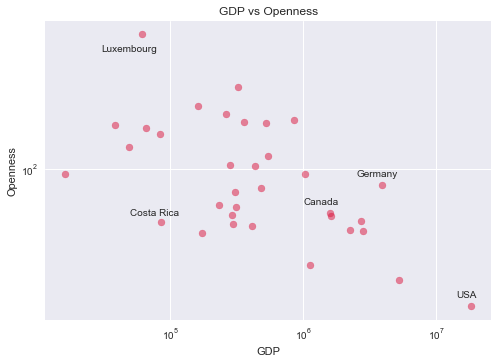

In [203]:
plt.scatter(df_nomulti.loc[df_nomulti['year']==2015]['adj_gdp'],df_nomulti.loc[df_nomulti['year']==2015]['openness'],alpha = .5,
           color='crimson')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('GDP')
plt.ylabel('Openness')
plt.title('GDP vs Openness')
plt.annotate('USA',(14000000,30))
plt.annotate('Luxembourg',(30437,300))
plt.annotate('Canada',(1004850,72))
plt.annotate('Germany',(2509081,93))
plt.annotate('Costa Rica',(50240,65))

Text(0, 0.5, '% Change in Compensation')

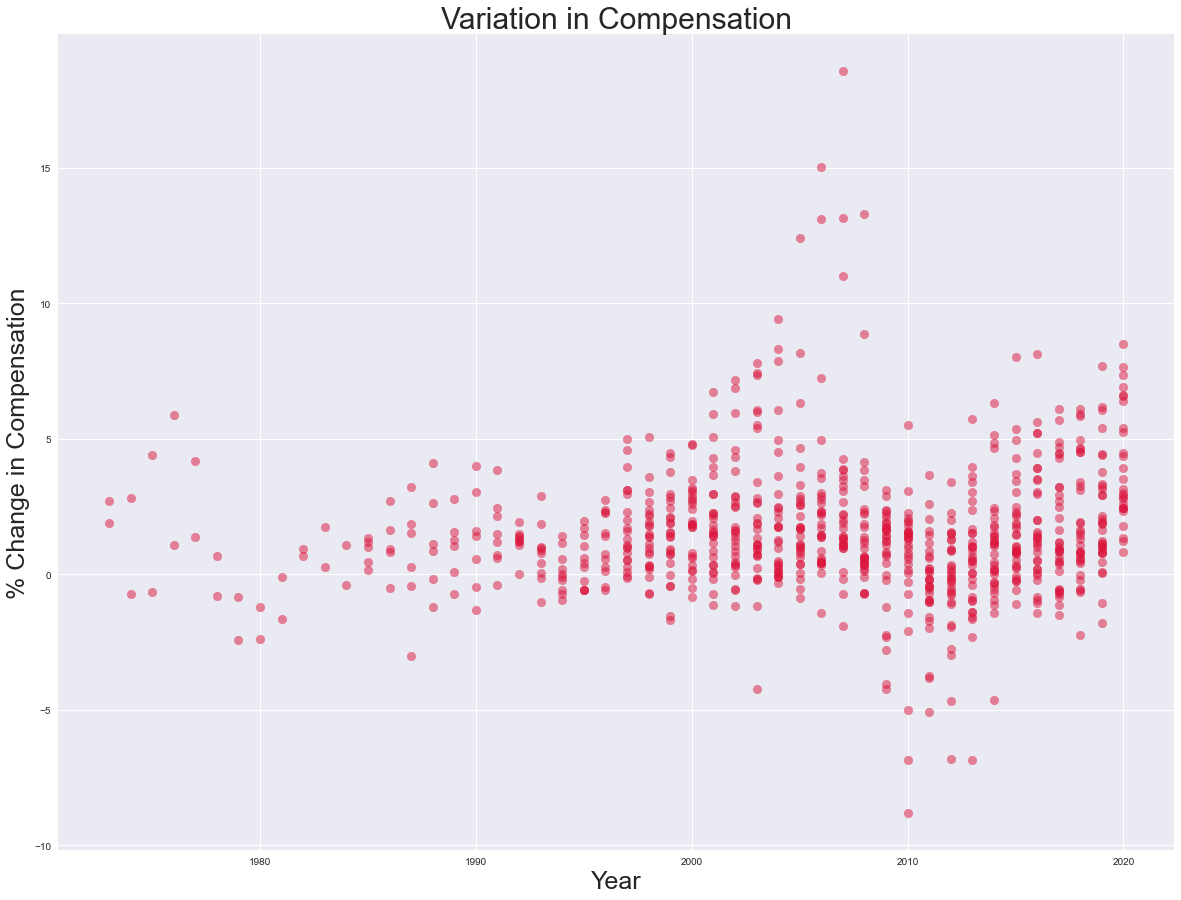

In [204]:
fig, axs = plt.subplots(1,figsize=(20,15))
axs.scatter(df.reset_index()['year'], df['roll_comp'],alpha=.5,c='crimson',s = 75)
axs.set_title('Variation in Compensation',size = 30)
axs.set_xlabel('Year',size =25)
axs.set_ylabel('% Change in Compensation',size = 25)


# Creating 1991 Summary Graphs

In [19]:
df_91 = df_nomulti[df_nomulti['country'].isin(pre91)].loc[df_nomulti['year']>1990]
pre_91 = list(set(df_91.sort_values('openness')['country']))

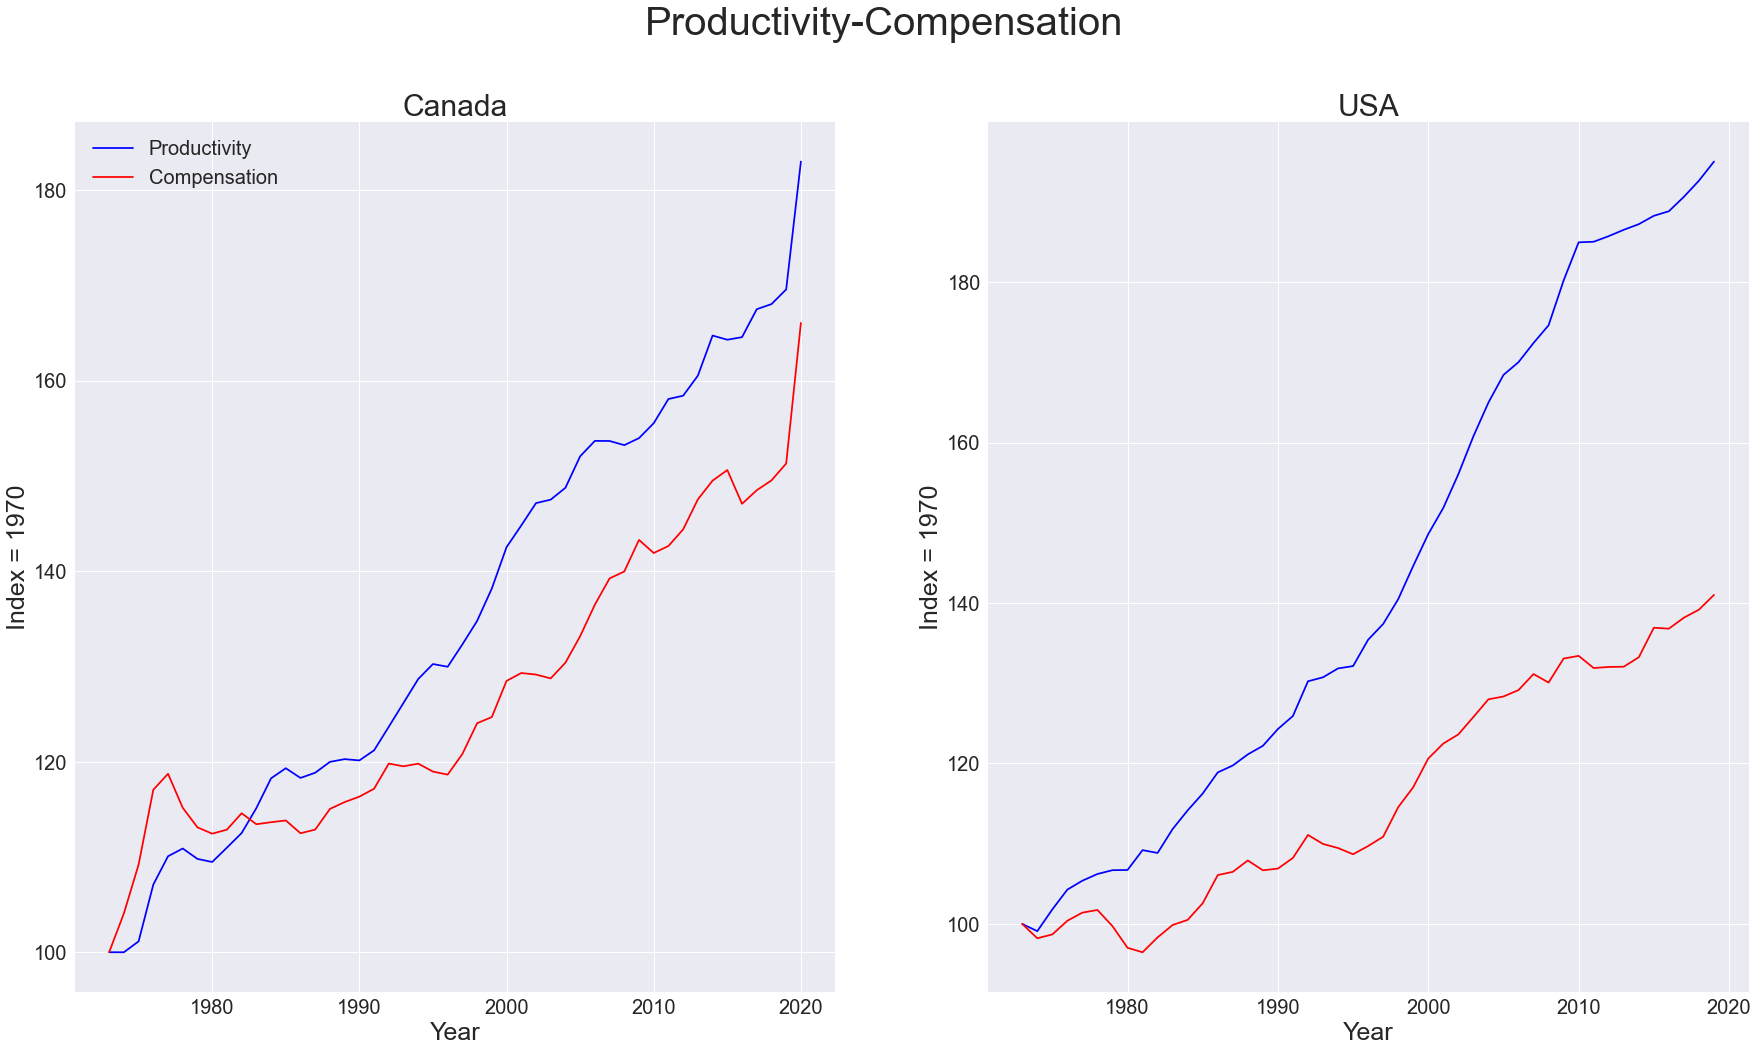

In [20]:
temp = df.reset_index()
temp = temp.loc[temp['year']>1991].set_index(['country','year'])
plt.style.use('seaborn')

prod_CAN = df.loc['CAN'][['prod']]*100/df.loc['CAN'][['prod']].loc[1973]
comp_CAN = df.loc['CAN'][['adj_comp']]*100/df.loc['CAN'][['adj_comp']].loc[1973]
prod_USA = df.loc['USA'][['prod']]*100/df.loc['USA'][['prod']].loc[1973]
comp_USA = df.loc['USA'][['adj_comp']]*100/df.loc['USA'][['adj_comp']].loc[1973]

x = df.loc['CAN'].reset_index()['year']
x_USA = df.loc['USA'].reset_index()['year']

fig, axs = plt.subplots(1,2,figsize = (30,16))
fig.suptitle('Productivity-Compensation',size=40)
for i in [0,1]: 
    axs[i].tick_params(axis = 'both', which = 'major', labelsize = 20)
    axs[i].set_xlabel('Year', size=25)
    axs[i].set_ylabel('Index = 1970', size=25)

axs[0].set_title('Canada',size = 30)
axs[0].plot(x,prod_CAN,color = 'b',label = 'Productivity')
axs[0].plot(x,comp_CAN, color = 'r', label = 'Compensation')

axs[1].set_title('USA',size = 30)
axs[1].plot(x_USA,prod_USA,color = 'b',label = 'Productivity')
axs[1].plot(x_USA,comp_USA, color = 'r', label = 'Compensation')

axs[0].legend(fontsize=20)




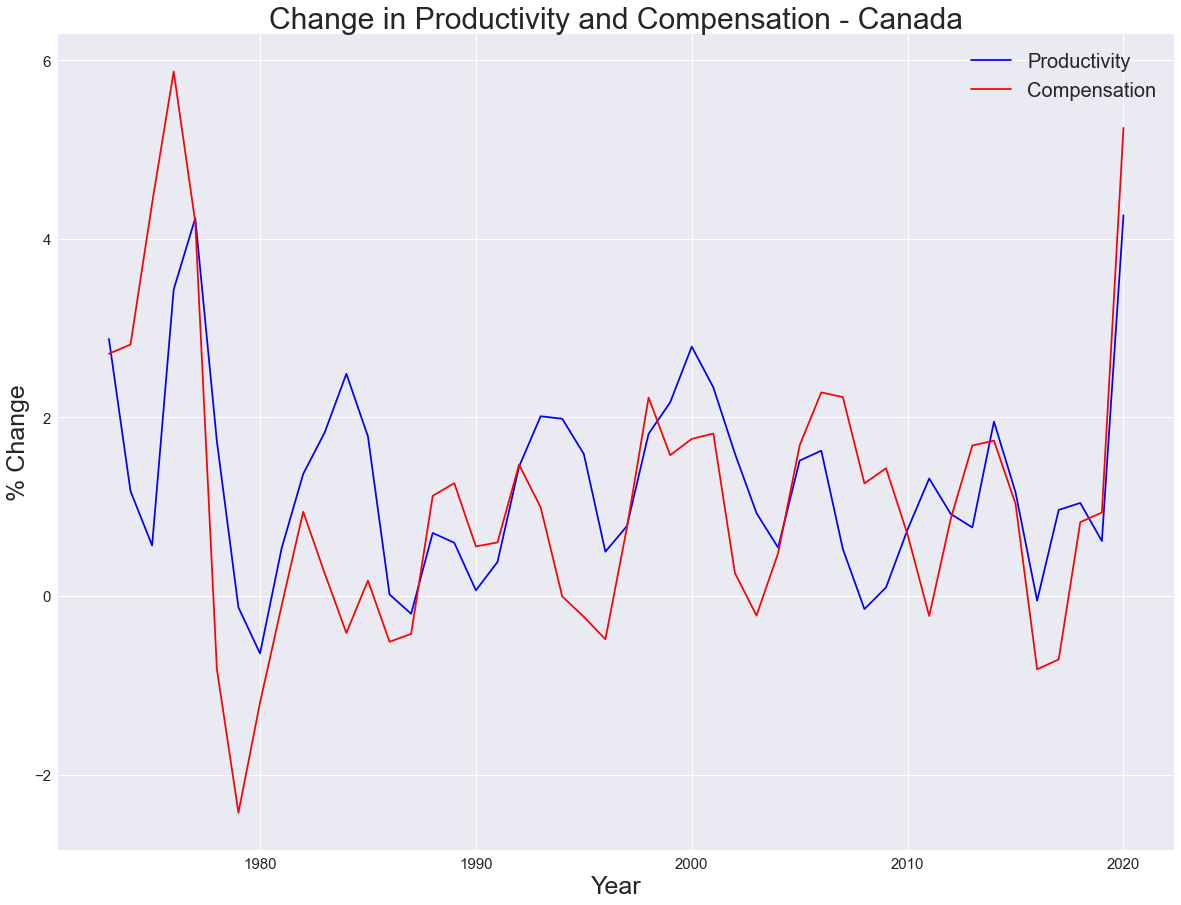

In [21]:
fig, axs = plt.subplots(1,figsize=(20,15))
x = df.loc['CAN'].reset_index()['year']
axs.plot(x,df.loc['CAN']['roll_prod'],label='Productivity',color = 'b')
axs.plot(x,df.loc['CAN']['roll_comp'],label='Compensation',color='r')
axs.tick_params(axis = 'both', which = 'major', labelsize = 15)
axs.set_xlabel('Year', size=25)
axs.set_ylabel('% Change', size=25)
axs.set_title('Change in Productivity and Compensation - Canada',size=30)
axs.legend(fontsize=20)

## Regression 

The full model is as follows:
<br/>
<br/>
$$RollingCompensation_{it} = \alpha + \beta(RollingProductivity_{it}*Openness_{it})+\gamma_1 RollingProductivity_{it} + \gamma_2Openness_{it} +\gamma_3Country_{i} + \gamma_4Decade_{t}$$
<br/>
$$+ \gamma_5RollingUnemployment_{it}+\gamma_6RollingUnemployment_{it-1}+\gamma_7Size_{it}+\epsilon_{it}$$
<br/><br/>List of Regressions Performed:
<ul>
<li>General Regression
<li>European Data Only
<li>Size Controls
<li>No Lag Unemployment Control
<li>No Unemployment Controls
<li>No Decade Fixed Effects

In [146]:
#General Regression
endog = df['roll_comp']
exog = df[['open_prod','roll_prod','openness','roll_unemp','lag_roll_unemp','gdp']].join(pd.get_dummies(df['decade'
        ])).rename({4:'2010s',3:'2000s',2:'1990s',1:'1980s',0:'1970s'},axis=1).drop('1970s',axis=1).assign(cons = [1]*len(endog))
#regression
reg = PanelOLS(endog,exog,entity_effects=True,time_effects=False,other_effects=None)
results = reg.fit(cov_type='clustered', cluster_entity=True)


In [147]:
df['residuals'] = results.fitted_values['fitted_values']-df['roll_comp']
df['resid_sq']  = df['residuals']**2
df['fitted'] = results.fitted_values

Text(0, 0.5, 'Residuals')

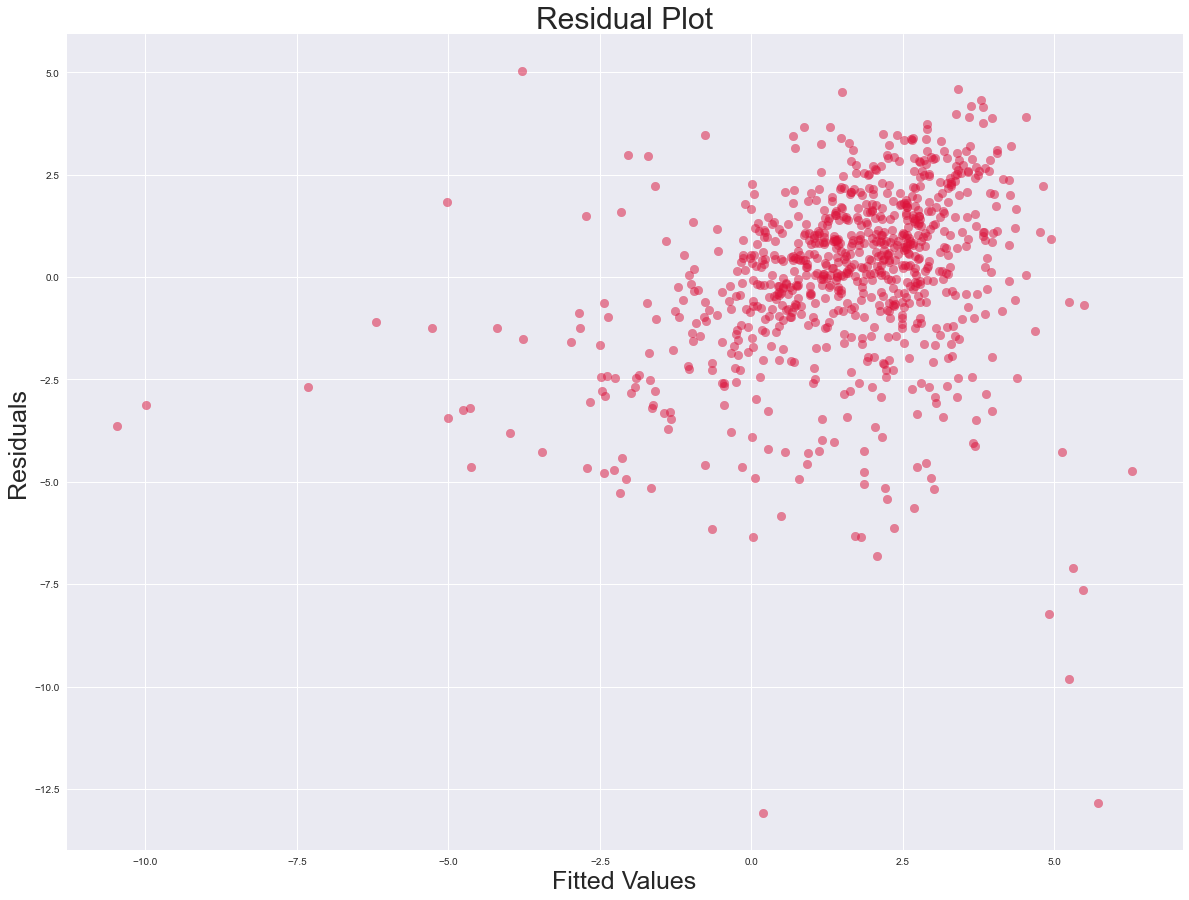

In [193]:
fig, axs = plt.subplots(1,figsize=(20,15))
axs.scatter(df['fitted'],df['residuals'],alpha = .5,s=75,c='crimson')
axs.set_title('Residual Plot',size=30)
axs.set_xlabel('Fitted Values',size=25)
axs.set_ylabel('Residuals',size=25)

Showing the top 10 residuals, 6 of them are latvian, therefore I regress with no latvia

In [201]:
print(df.nlargest(10,'roll_comp')['roll_comp'])
print(df.nsmallest(10,'roll_comp')['roll_comp'])

country  year
LVA      2007    18.561407
         2006    15.052152
         2008    13.281848
EST      2007    13.138192
LTU      2006    13.105606
LVA      2005    12.413599
LTU      2007    11.016224
LVA      2004     9.409557
EST      2008     8.875095
LTU      2020     8.485993
Name: roll_comp, dtype: float64
country  year
LVA      2010   -8.801027
GRC      2013   -6.869775
LTU      2010   -6.862080
GRC      2012   -6.829213
         2011   -5.086898
HUN      2010   -5.014339
PRT      2012   -4.669389
GRC      2014   -4.628332
ISR      2003   -4.229443
LTU      2009   -4.225930
Name: roll_comp, dtype: float64


In [152]:
df.nlargest(10,'resid_sq')

terms of trade     prod%        prod    avg_comp  unemployment  \
country year                                                                   
LVA     2008       99.146917 -8.435719  146.407090   84.286664      7.741667   
        2007      100.797551  7.511471  159.895418   69.824055      6.058333   
        2006       96.338055  5.743204  148.724054   50.865114      7.041667   
EST     2007       98.561608  7.547773  143.196882   67.978053      4.600000   
LTU     2006       97.569961  7.997152  180.095228   65.043110      5.791667   
LVA     2005       96.912856  8.225511  140.646442   41.070116     10.050000   
EST     2008       98.735355 -3.468884  138.229548   76.056443      5.516667   
GRC     2020       96.947835  2.352639  120.969542  104.136921     16.441670   
LVA     2016      103.040802  2.617985  182.323194  107.306558      9.633333   
        2015      100.000000  4.410931  177.671774  100.000000      9.883333   

                     gdp    openness    adj_comp        adj_gdp  \
country year                                                      
LVA     2008   42617.067   91.176455   92.831589   46937.556418   
        2007   40126.442   95.573286   88.747576   51001.398882   
        2006   35181.638  100.132983   71.175597   49229.696075   
EST     2007   29756.670  133.987601   86.048669   37666.890212   
LTU     2006   53900.646  124.335445   86.893554   72007.914630   
LVA     2005   31150.197  100.235751   61.225758   46437.522175   
EST     2008   30488.762  136.689050   87.234947   34969.891295   
GRC     2020  299066.319   71.582921  104.234380  299346.207704   
LVA     2016   52362.250  118.834859  107.155897   52288.732043   
        2015   49384.341  122.227576  100.000000   49384.341000   

              %_change_comp  %_change_prod  roll_comp  roll_unemp  roll_prod  \
country year                                                                   
LVA     2008       4.499086      -8.812894  13.281848    6.900000  -0.785079   
        2007      22.064609       7.242736  18.561407    6.550000   6.413536   
        2006      15.058204       5.584337  15.052152    8.545834   6.744515   
EST     2007      16.380994       7.276496  13.138192    5.270834   6.096513   
LTU     2006      15.763198       7.693467  13.105606    7.054167   7.190427   
LVA     2005      15.046100       7.904693  12.413599   10.900000   9.100733   
EST     2008       1.369196      -3.530478   8.875095    5.058334   1.873009   
GRC     2020      10.818071       2.325391   6.382226   16.887500   2.778470   
LVA     2016       6.911457       2.584302   8.149911    9.758333   3.450361   
        2015       9.388365       4.316419   8.037816   10.366667   3.512665   

               open_prod  lag_roll_unemp  decade  residuals    resid_sq  \
country year                                                              
LVA     2008  -71.580688        6.550000       3 -13.083176  171.169492   
        2007  612.962746        8.545834       3 -12.839640  164.856345   
        2006  675.348377       10.900000       3  -9.809402   96.224376   
EST     2007  816.857194        6.958334       3  -8.225491   67.658708   
LTU     2006  894.024968        9.604169       3  -7.639320   58.359212   
LVA     2005  912.218856       11.695835       3  -7.099090   50.397077   
EST     2008  256.019811        5.270834       3  -6.805155   46.310136   
GRC     2020  198.890977       18.320830       4  -6.359835   40.447498   
LVA     2016  410.023108       10.366667       4  -6.345653   40.267311   
        2015  429.344477       11.362500       4  -6.333284   40.110484   

                fitted  
country year            
LVA     2008  0.198672  
        2007  5.721767  
        2006  5.242750  
EST     2007  4.912701  
LTU     2006  5.466286  
LVA     2005  5.314509  
EST     2008  2.069940  
GRC     2020  0.022391  
LVA     2016  1.804258  
        2015  1.704532

In [153]:
df_no_LVA = df.drop('LVA')

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [155]:
#No Latvia
endog = df_no_LVA['roll_comp']
exog = df_no_LVA[['open_prod','roll_prod','openness','roll_unemp','lag_roll_unemp','gdp']].join(pd.get_dummies(df['decade'
        ])).rename({4:'2010s',3:'2000s',2:'1990s',1:'1980s',0:'1970s'},axis=1).drop('1970s',axis=1).assign(cons = [1]*len(endog))
#regression
reg = PanelOLS(endog,exog,entity_effects=True,time_effects=False,other_effects=None)
results = reg.fit(cov_type='clustered', cluster_entity=True)
results

Dep. Variable:,roll_comp,R-squared:,0.4620
Estimator:,PanelOLS,R-squared (Between):,-0.2676
No. Observations:,815,R-squared (Within):,0.4620
Date:,"Tue, Apr 26 2022",R-squared (Overall):,0.2195
Time:,17:37:47,Log-likelihood,-1401.9
Cov. Estimator:,Clustered,,
,,F-statistic:,66.204
Entities:,35,P-value,0.0000
Avg Obs:,23.286,Distribution:,"F(10,771)"
Min Obs:,0.0000,,
Max Obs:,48.000,F-statistic (robust):,18.503


In [158]:
#No Latvia
df_no_USA = df.drop('USA')
endog = df_no_USA['roll_comp']
exog = df_no_USA[['open_prod','roll_prod','openness','roll_unemp','lag_roll_unemp','gdp']].join(pd.get_dummies(df['decade'
        ])).rename({4:'2010s',3:'2000s',2:'1990s',1:'1980s',0:'1970s'},axis=1).drop('1970s',axis=1).assign(cons = [1]*len(endog))
#regression
reg = PanelOLS(endog,exog,entity_effects=True,time_effects=False,other_effects=None)
results = reg.fit(cov_type='clustered', cluster_entity=True)
results

Dep. Variable:,roll_comp,R-squared:,0.4813
Estimator:,PanelOLS,R-squared (Between):,-0.2967
No. Observations:,786,R-squared (Within):,0.4813
Date:,"Tue, Apr 26 2022",R-squared (Overall):,0.2315
Time:,17:39:27,Log-likelihood,-1444.6
Cov. Estimator:,Clustered,,
,,F-statistic:,68.845
Entities:,34,P-value,0.0000
Avg Obs:,23.118,Distribution:,"F(10,742)"
Min Obs:,1.0000,,
Max Obs:,48.000,F-statistic (robust):,1.265e+13


In [23]:
#European Data only
endog = df.loc[list(eu)]['roll_comp']
exog = df.loc[list(eu)][['open_prod','roll_prod','openness','roll_unemp','lag_roll_unemp']].join(pd.get_dummies(df['decade'
      ])).rename({4:'2010s',3:'2000s',2:'1990s',1:'1980s',0:'1970s'},axis=1).drop(['1970s','2010s'],axis = 1).assign(cons = [1]*len(endog))
#regressing
reg = PanelOLS(endog,exog,entity_effects=True,time_effects=False,other_effects=None,check_rank=False,drop_absorbed = True)
results = reg.fit(cov_type='clustered', cluster_entity=True)
results

Dep. Variable:,roll_comp,R-squared:,0.4904
Estimator:,PanelOLS,R-squared (Between):,-0.1562
No. Observations:,624,R-squared (Within):,0.4904
Date:,"Tue, Apr 26 2022",R-squared (Overall):,0.3011
Time:,15:30:26,Log-likelihood,-1181.6
Cov. Estimator:,Clustered,,
,,F-statistic:,70.973
Entities:,34,P-value,0.0000
Avg Obs:,18.353,Distribution:,"F(8,590)"
Min Obs:,0.0000,,
Max Obs:,36.000,F-statistic (robust):,17.755


In [ ]:
#Size Controls
endog = df['roll_comp']
exog = df[['open_prod','roll_prod','openness','roll_unemp','lag_roll_unemp','gdp']].join(pd.get_dummies(df['decade'
        ])).rename({4:'2010s',3:'2000s',2:'1990s',1:'1980s',0:'1970s'},axis=1).drop('1970s',axis=1).assign(cons = [1]*len(endog))
#regression
reg = PanelOLS(endog,exog,entity_effects=True,time_effects=False,other_effects=None)
results = reg.fit(cov_type='clustered', cluster_entity=True)
results

In [25]:
#No Lag Unemployment Control
endog = df['roll_comp']
exog = df[['open_prod','roll_prod','openness','roll_unemp']].join(pd.get_dummies(df['decade'
        ])).rename({4:'2010s',3:'2000s',2:'1990s',1:'1980s',0:'1970s'},axis=1).drop('1970s',axis=1).assign(cons = [1]*len(endog))
#regression
reg = PanelOLS(endog,exog,entity_effects=True,time_effects=False,other_effects=None)
results = reg.fit(cov_type='clustered', cluster_entity=True)
results

Dep. Variable:,roll_comp,R-squared:,0.4454
Estimator:,PanelOLS,R-squared (Between):,-0.2169
No. Observations:,833,R-squared (Within):,0.4454
Date:,"Tue, Apr 26 2022",R-squared (Overall):,0.2361
Time:,15:30:26,Log-likelihood,-1541.4
Cov. Estimator:,Clustered,,
,,F-statistic:,79.313
Entities:,35,P-value,0.0000
Avg Obs:,23.800,Distribution:,"F(8,790)"
Min Obs:,1.0000,,
Max Obs:,48.000,F-statistic (robust):,10.795


In [26]:
#No Unemployment Controls
endog = df['roll_comp']
exog = df[['open_prod','roll_prod','openness']].join(pd.get_dummies(df['decade'
        ])).rename({4:'2010s',3:'2000s',2:'1990s',1:'1980s',0:'1970s'},axis=1).drop('1970s',axis=1).assign(cons = [1]*len(endog))
#regression
reg = PanelOLS(endog,exog,entity_effects=True,time_effects=False,other_effects=None)
results = reg.fit(cov_type='clustered', cluster_entity=True)
results

Dep. Variable:,roll_comp,R-squared:,0.2289
Estimator:,PanelOLS,R-squared (Between):,0.4761
No. Observations:,833,R-squared (Within):,0.2289
Date:,"Tue, Apr 26 2022",R-squared (Overall):,0.2998
Time:,15:30:26,Log-likelihood,-1678.6
Cov. Estimator:,Clustered,,
,,F-statistic:,33.551
Entities:,35,P-value,0.0000
Avg Obs:,23.800,Distribution:,"F(7,791)"
Min Obs:,1.0000,,
Max Obs:,48.000,F-statistic (robust):,7.8463


In [27]:
#No Decade Fixed Effects
endog = df['roll_comp']
exog = df[['open_prod','roll_prod','openness','roll_unemp','lag_roll_unemp']].assign(cons = [1]*len(endog))
#regression
reg = PanelOLS(endog,exog,entity_effects=True,time_effects=False,other_effects=None)
results = reg.fit(cov_type='clustered', cluster_entity=True)
results

Dep. Variable:,roll_comp,R-squared:,0.4756
Estimator:,PanelOLS,R-squared (Between):,-0.2976
No. Observations:,833,R-squared (Within):,0.4756
Date:,"Tue, Apr 26 2022",R-squared (Overall):,0.2193
Time:,15:30:26,Log-likelihood,-1518.1
Cov. Estimator:,Clustered,,
,,F-statistic:,143.83
Entities:,35,P-value,0.0000
Avg Obs:,23.800,Distribution:,"F(5,793)"
Min Obs:,1.0000,,
Max Obs:,48.000,F-statistic (robust):,20.733
